In [ ]:
!nvidia-smi

Wed May 26 14:16:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow_privacy

     |████████████████████████████████| 194kB 14.7MB/s 


In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
!ls -lrt /content/drive/MyDrive/

total 96228
-rw------- 1 root root  2385789 Apr 28 11:54  df.csv
drwx------ 2 root root     4096 Apr 29 08:56 'Colab Notebooks'
-rw------- 1 root root  2760366 May  2 18:25  newdf.csv
drwx------ 2 root root     4096 May  4 10:59  Datasets
-rw------- 1 root root 28883068 May 10 13:58  MNIST1.zip
-rw------- 1 root root 28881137 May 10 14:01  MNIST2.zip
-rw------- 1 root root 28882506 May 10 14:03  MNIST3.zip
-rw------- 1 root root  1945158 May 14 15:18  MNIST1_train.csv
-rw------- 1 root root   298391 May 14 15:18  MNIST1_test.csv
-rw------- 1 root root  1945158 May 14 17:29  MNIST2_train.csv
-rw------- 1 root root   298391 May 14 17:29  MNIST2_test.csv
-rw------- 1 root root      151 May 23 21:50  class_accuracy.gsheet
-rw------- 1 root root     1975 May 26 10:13  class_accuracy.csv
-rw------- 1 root root  1945158 May 26 13:54  MNIST3_train.csv
-rw------- 1 root root   298391 May 26 13:54  MNIST3_test.csv


In [ ]:
!du -hs /content/drive/MyDrive/

96M	/content/drive/MyDrive/


In [ ]:
!cp -R /content/drive/MyDrive/MNIST3.zip ./

In [ ]:
!unzip -q ./MNIST3.zip

In [ ]:
pwd

'/content'

In [ ]:
!ls -lrt /content/MNIST3/

total 8
drwxr-xr-x 12 root root 4096 May 10 14:02 train
drwxr-xr-x 12 root root 4096 May 10 14:03 test


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from tqdm import tqdm as tqdm


import torchvision
import random
import os
import glob
import copy
from torchsummary import summary

import matplotlib.pyplot as plt

seed = 42
best_model = None
best_loss = 0.
best_test_loss = 0.
best_test_acc = 0.
best_pred_labels = []
true_labels = []

pred_labels = []
test_acc = 0.
test_loss = 0.

# device = torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
train_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor(),])
test_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor(),])

In [ ]:
PATH_TO_MNIST3 = '/content/MNIST3'

trainset = datasets.ImageFolder(root=PATH_TO_MNIST3+'/train',transform=train_transform)
testset = datasets.ImageFolder(root=PATH_TO_MNIST3+'/test',transform=test_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(type(images))
print(type(labels))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([128, 1, 28, 28])
torch.Size([128])


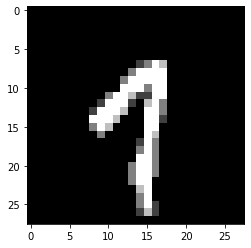

In [ ]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray');

Text(0.5, 1.0, 'MNIST3 Training Dataset Distribution')

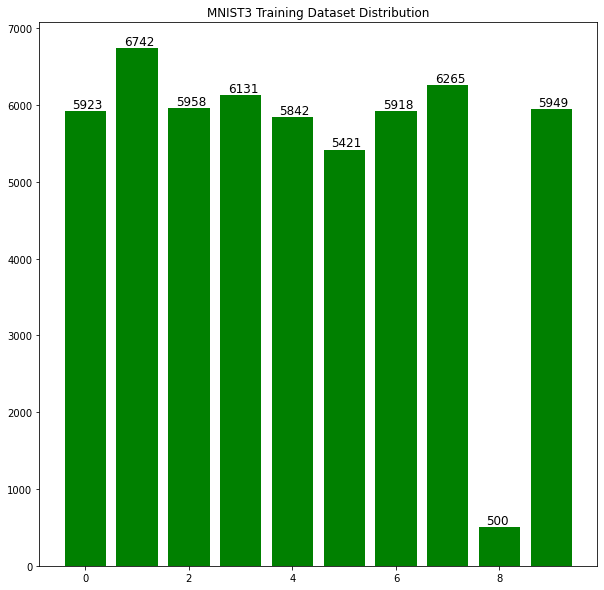

In [ ]:
import matplotlib.pyplot as plt
import collections

class_freq_counter = collections.Counter(trainloader.dataset.targets)
class_freq = [val for val in class_freq_counter.values()]

plt.figure(figsize = (10,10))
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for idx, val in enumerate(class_freq):
  plt.text((idx-0.25),val+40, str(val), fontsize=12)
plt.bar(classes, class_freq, color='green')
plt.title("MNIST3 Training Dataset Distribution")

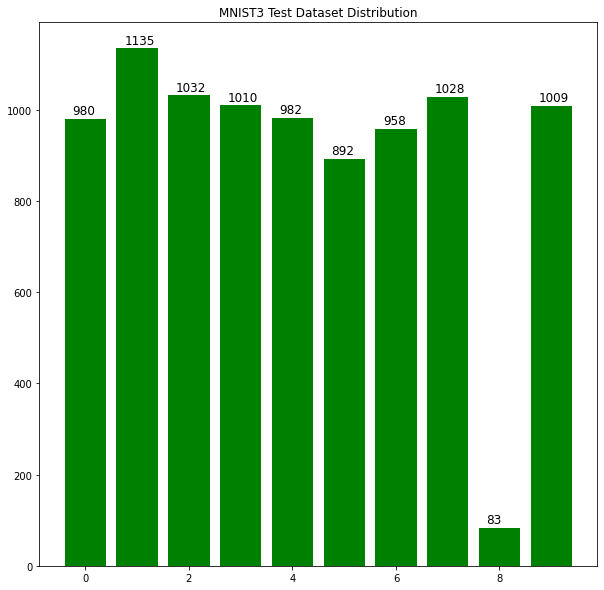

In [ ]:
import matplotlib.pyplot as plt
import collections

class_freq_counter = collections.Counter(testloader.dataset.targets)
class_freq = [val for val in class_freq_counter.values()]

plt.figure(figsize = (10,10))
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for idx, val in enumerate(class_freq):
  plt.text((idx-0.25),val+10, str(val), fontsize=12)
#plt.text(0,980, "980")
#plt.text(1,1135, "1135")
plt.bar(classes, class_freq, color='green')
plt.title("MNIST3 Test Dataset Distribution")
plt.show()

In [ ]:
class_freq

[980, 1135, 1032, 1010, 982, 892, 958, 1028, 83, 1009]

In [ ]:
print("Total number of samples in Train dataset :", np.sum(class_freq))

Total number of samples in Train dataset : 9109


In [ ]:
class Model(nn.Module):
    """Class used to initialize model of student/teacher"""

    def __init__(self):

        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x

In [ ]:
def accuracy(predictions, dataset):
    """Evaluates accuracy for given set of predictions and true labels.
       Args:
           predictions[torch tensor]: predictions made by classifier.
           labels[torch tensor]: true labels of the dataset.
       Returns:
           accuracy[float]: accuracy of classifier.
    """

    total = 0.0
    correct = 0.0

    for j in range(0, len(dataset)):
        correct += (predictions[j].long() == dataset[j].long()).sum().item()
        total += len(dataset[j])

    return (correct / total) * 100

In [ ]:
model = Model().cuda()

### DP-SGD with eps = 0.517

In [ ]:
batchsize = 256
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

#from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent


rdp = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=53913, batch_size=batchsize, noise_multiplier=0.75, epochs=50, delta=1e-4)
#epsilon = get_privacy_spent(5218, rdp, target_delta=1e-5)[0]
rdp

DP-SGD with sampling rate = 0.475% and noise_multiplier = 0.75 iterated over 10530 steps satisfies differential privacy with eps = 5.02 and delta = 0.0001.
The optimal RDP order is 4.0.


(5.016766471137041, 4.0)

In [ ]:
train_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor(),])
test_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor(),])

In [ ]:
PATH_TO_MNIST3 = '/content/MNIST3'

trainset = datasets.ImageFolder(root=PATH_TO_MNIST3+'/train',transform=train_transform)
testset = datasets.ImageFolder(root=PATH_TO_MNIST3+'/test',transform=test_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=True)

In [ ]:
def clip_grad(parameters, max_norm, norm_type=2):
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type

In [ ]:
def train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train'):
    """
    Differentially Private version of the training procedure
    :param trainloader:
    :param model:
    :param optimizer:
    :param epoch:
    :return:
    """
    model.train()
    running_loss = 0.0
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    #num_microbatches = 32*2
    num_microbatches = 32
    S = 1
    z = 0.75  #DP-SGD with sampling rate = 0.475% and noise_multiplier = 0.75 iterated over 10530 steps satisfies differential privacy with eps = 5.02 and delta = 0.0001.
              #The optimal RDP order is 4.0.
    sigma = z * S
    for batch_idx, data in tqdm(enumerate(trainloader, 0), leave=True):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        #print(loss.shape)
        running_loss += torch.mean(loss).item()

        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())

        if loss.shape[0] == 121:
          losses = torch.mean(loss.reshape(121, -1), dim=1)
        else:
          losses = torch.mean(loss.reshape(num_microbatches, -1), dim=1)
        saved_var = dict()
        for tensor_name, tensor in model.named_parameters():
            saved_var[tensor_name] = torch.zeros_like(tensor)

        for j in losses:
            j.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), S)
            for tensor_name, tensor in model.named_parameters():
                new_grad = tensor.grad
                saved_var[tensor_name].add_(new_grad)
            model.zero_grad()

        for tensor_name, tensor in model.named_parameters():
            if device.type =='cuda':
                noise = torch.cuda.FloatTensor(tensor.grad.shape).normal_(0, sigma)
                #noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            else:
                noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            saved_var[tensor_name].add_(noise)
            tensor.grad = saved_var[tensor_name] / num_microbatches
        optimizer.step()

        #print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {loss}', end='', flush=True)
        ##print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
        epoch_loss += torch.mean(loss.detach().cpu()).item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)

        '''if i > 0 and i % 20 == 0:
            #             logger.info('[%d, %5d] loss: %.3f' %
            #                   (epoch + 1, i + 1, running_loss / 2000))
            plot(epoch * len(trainloader) + i, running_loss, 'Train Loss')
            running_loss = 0.0'''
    #print("RETURNING........")
    return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [ ]:
def test(model, testloader, criterion, optimizer, lr_scheduler, phase='test'):
    model.eval()
    #correct = 0
    #total = 0

    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, data in  enumerate(testloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            true_labels.append(labels.detach().cpu())
            pred_labels.append(preds.detach().cpu())

            # print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {loss}', end='', flush=True)
            ##print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
            epoch_loss += torch.mean(loss.detach().cpu()).item()
            epoch_acc += torch.sum(preds == labels.data)
            batch_num += 1
            samples_num += len(labels)

            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()
        #print("TESTING.....")
        return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [ ]:
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)


In [ ]:
train_nrun_losses = []
val_nrun_losses = []
test_nrun_losses = []
test_nrun_true_labels = []
test_nrun_pred_labels = []
test_nrun_acc = []

def train_n(runs, nepochs = 50):
  for run in range(runs):
    model = Model().cuda()
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
    print("Train Log of run ", run)
    train_losses = []
    val_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_model = None
    for epoch in range(nepochs):
        print('='*15, f'Epoch: {epoch}')
    
        #train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train')
        #test(model, testloader, criterion, optimizer, lr_scheduler, phase='test')

        train_loss, train_acc, _, _ = train_dp(model, train_loader, criterion, optimizer, lr_scheduler)
        #val_loss, val_acc, _, _ = test(model, test_loader, criterion, optimizer, lr_scheduler, phase='val')
        ###test_loss, test_acc, _, _ = test(model, test_loader, criterion, optimizer, lr_scheduler, phase='val') ### IMPORTANT :::: Although this is test_dataloader, the name for phase is given as 'val', it is just a incorrect label and nothing else
        #test_loss, test_acc, true_labels, pred_labels = run_epoch(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
    
        ##print()
        ##print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
        #print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
        ##print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
        ##print()
    
        ##train_losses.append(train_loss)
        ##train_accuracies.append(train_acc)
        #val_losses.append(test_loss)
        #test_losses.append(test_loss)
        ##test_accuracies.append(test_acc)
    
        torch.save({'epoch': epoch, 'model': model.state_dict()}, f'covnet-{seed}.pt')
    
        '''
        if best_model is None or test_loss < best_loss:
            best_model = copy.deepcopy(model)
            #best_loss = val_loss
            best_test_loss = test_loss
            best_test_acc = test_acc 
            best_pred_labels = pred_labels
            torch.save({'epoch': epoch, 'model': model.state_dict()}, f'covnet-{seed}.pt')
        '''
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_loss, test_acc, _, _ = test(model, test_loader, criterion, optimizer, lr_scheduler, phase='test')
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    train_nrun_losses.append(train_losses)
    test_nrun_losses.append(test_losses)
    Test_loss_after_training, test_acc_after_training, true_labels_test, pred_labels_test = test(model, test_loader, criterion, optimizer, lr_scheduler, phase='test')
    test_nrun_true_labels.append(true_labels_test)
    test_nrun_pred_labels.append(pred_labels_test)
    test_nrun_acc.append(test_acc_after_training)


In [ ]:
train_n(5, 50)

1it [00:00,  5.25it/s]

Train Log of run  0
=============== Epoch: 0


214it [00:36,  5.91it/s]
1it [00:00,  5.96it/s]

=============== Epoch: 1


214it [00:36,  5.89it/s]
1it [00:00,  5.93it/s]

=============== Epoch: 2


214it [00:36,  5.88it/s]
1it [00:00,  5.79it/s]

=============== Epoch: 3


214it [00:36,  5.89it/s]
1it [00:00,  5.90it/s]

=============== Epoch: 4


214it [00:36,  5.89it/s]
1it [00:00,  5.94it/s]

=============== Epoch: 5


214it [00:36,  5.90it/s]
1it [00:00,  5.92it/s]

=============== Epoch: 6


214it [00:36,  5.91it/s]
1it [00:00,  5.71it/s]

=============== Epoch: 7


214it [00:36,  5.91it/s]
1it [00:00,  5.81it/s]

=============== Epoch: 8


214it [00:36,  5.90it/s]
1it [00:00,  5.96it/s]

=============== Epoch: 9


214it [00:36,  5.90it/s]
1it [00:00,  5.95it/s]

=============== Epoch: 10


214it [00:36,  5.91it/s]
1it [00:00,  5.83it/s]

=============== Epoch: 11


214it [00:36,  5.89it/s]
1it [00:00,  5.89it/s]

=============== Epoch: 12


214it [00:36,  5.89it/s]
1it [00:00,  5.77it/s]

=============== Epoch: 13


214it [00:36,  5.90it/s]
1it [00:00,  5.97it/s]

=============== Epoch: 14


214it [00:36,  5.91it/s]
1it [00:00,  5.82it/s]

=============== Epoch: 15


214it [00:36,  5.89it/s]
1it [00:00,  6.01it/s]

=============== Epoch: 16


214it [00:36,  5.89it/s]
1it [00:00,  5.73it/s]

=============== Epoch: 17


214it [00:36,  5.90it/s]
1it [00:00,  6.00it/s]

=============== Epoch: 18


214it [00:36,  5.92it/s]
1it [00:00,  5.96it/s]

=============== Epoch: 19


214it [00:36,  5.89it/s]
1it [00:00,  5.85it/s]

=============== Epoch: 20


214it [00:36,  5.89it/s]
1it [00:00,  5.96it/s]

=============== Epoch: 21


214it [00:36,  5.89it/s]
1it [00:00,  5.95it/s]

=============== Epoch: 22


214it [00:36,  5.90it/s]
1it [00:00,  5.77it/s]

=============== Epoch: 23


214it [00:36,  5.90it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 24


214it [00:36,  5.90it/s]
1it [00:00,  5.78it/s]

=============== Epoch: 25


214it [00:35,  5.95it/s]
1it [00:00,  5.95it/s]

=============== Epoch: 26


214it [00:35,  5.96it/s]
1it [00:00,  5.97it/s]

=============== Epoch: 27


214it [00:35,  5.95it/s]
1it [00:00,  5.67it/s]

=============== Epoch: 28


214it [00:36,  5.94it/s]
1it [00:00,  5.93it/s]

=============== Epoch: 29


214it [00:35,  5.97it/s]
1it [00:00,  5.94it/s]

=============== Epoch: 30


214it [00:35,  5.97it/s]
1it [00:00,  5.97it/s]

=============== Epoch: 31


214it [00:35,  5.97it/s]
1it [00:00,  6.02it/s]

=============== Epoch: 32


214it [00:35,  5.98it/s]
1it [00:00,  6.00it/s]

=============== Epoch: 33


214it [00:35,  5.97it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 34


214it [00:35,  5.97it/s]
1it [00:00,  5.96it/s]

=============== Epoch: 35


214it [00:35,  5.97it/s]
1it [00:00,  5.85it/s]

=============== Epoch: 36


214it [00:35,  5.98it/s]
1it [00:00,  5.96it/s]

=============== Epoch: 37


214it [00:35,  5.95it/s]
1it [00:00,  6.03it/s]

=============== Epoch: 38


214it [00:35,  5.98it/s]
1it [00:00,  5.89it/s]

=============== Epoch: 39


214it [00:35,  5.97it/s]
1it [00:00,  6.00it/s]

=============== Epoch: 40


214it [00:35,  5.97it/s]
1it [00:00,  5.91it/s]

=============== Epoch: 41


214it [00:35,  5.96it/s]
1it [00:00,  5.67it/s]

=============== Epoch: 42


214it [00:35,  5.97it/s]
1it [00:00,  5.92it/s]

=============== Epoch: 43


214it [00:35,  5.97it/s]
1it [00:00,  5.96it/s]

=============== Epoch: 44


214it [00:36,  5.94it/s]
1it [00:00,  6.08it/s]

=============== Epoch: 45


214it [00:35,  5.95it/s]
1it [00:00,  5.57it/s]

=============== Epoch: 46


214it [00:36,  5.94it/s]
1it [00:00,  6.00it/s]

=============== Epoch: 47


214it [00:35,  5.95it/s]
1it [00:00,  6.13it/s]

=============== Epoch: 48


214it [00:36,  5.93it/s]
1it [00:00,  5.97it/s]

=============== Epoch: 49


214it [00:35,  5.96it/s]
1it [00:00,  5.81it/s]

Train Log of run  1
=============== Epoch: 0


214it [00:35,  5.96it/s]
1it [00:00,  5.94it/s]

=============== Epoch: 1


214it [00:35,  5.96it/s]
1it [00:00,  6.01it/s]

=============== Epoch: 2


214it [00:35,  5.97it/s]
1it [00:00,  5.97it/s]

=============== Epoch: 3


214it [00:35,  5.96it/s]
1it [00:00,  5.94it/s]

=============== Epoch: 4


214it [00:35,  5.95it/s]
1it [00:00,  5.95it/s]

=============== Epoch: 5


214it [00:35,  5.96it/s]
1it [00:00,  5.88it/s]

=============== Epoch: 6


214it [00:35,  5.95it/s]
1it [00:00,  5.96it/s]

=============== Epoch: 7


214it [00:36,  5.92it/s]
1it [00:00,  6.03it/s]

=============== Epoch: 8


214it [00:36,  5.93it/s]
1it [00:00,  6.00it/s]

=============== Epoch: 9


214it [00:36,  5.92it/s]
1it [00:00,  5.86it/s]

=============== Epoch: 10


214it [00:36,  5.93it/s]
1it [00:00,  5.95it/s]

=============== Epoch: 11


214it [00:36,  5.91it/s]
1it [00:00,  5.90it/s]

=============== Epoch: 12


214it [00:36,  5.93it/s]
1it [00:00,  5.91it/s]

=============== Epoch: 13


214it [00:36,  5.91it/s]
1it [00:00,  5.97it/s]

=============== Epoch: 14


214it [00:36,  5.93it/s]
1it [00:00,  5.93it/s]

=============== Epoch: 15


214it [00:36,  5.93it/s]
1it [00:00,  5.77it/s]

=============== Epoch: 16


214it [00:36,  5.92it/s]
1it [00:00,  5.85it/s]

=============== Epoch: 17


214it [00:36,  5.92it/s]
1it [00:00,  5.95it/s]

=============== Epoch: 18


214it [00:36,  5.93it/s]
1it [00:00,  5.88it/s]

=============== Epoch: 19


214it [00:36,  5.91it/s]
1it [00:00,  5.79it/s]

=============== Epoch: 20


214it [00:36,  5.91it/s]
1it [00:00,  5.94it/s]

=============== Epoch: 21


214it [00:36,  5.90it/s]
1it [00:00,  5.95it/s]

=============== Epoch: 22


214it [00:36,  5.92it/s]
1it [00:00,  6.03it/s]

=============== Epoch: 23


214it [00:36,  5.92it/s]
1it [00:00,  5.90it/s]

=============== Epoch: 24


214it [00:36,  5.92it/s]
1it [00:00,  5.99it/s]

=============== Epoch: 25


214it [00:36,  5.91it/s]
1it [00:00,  5.85it/s]

=============== Epoch: 26


214it [00:36,  5.93it/s]
1it [00:00,  5.93it/s]

=============== Epoch: 27


214it [00:36,  5.90it/s]
1it [00:00,  5.91it/s]

=============== Epoch: 28


214it [00:36,  5.91it/s]
1it [00:00,  5.89it/s]

=============== Epoch: 29


214it [00:36,  5.92it/s]
1it [00:00,  5.84it/s]

=============== Epoch: 30


214it [00:36,  5.91it/s]
1it [00:00,  5.94it/s]

=============== Epoch: 31


214it [00:36,  5.93it/s]
1it [00:00,  6.05it/s]

=============== Epoch: 32


214it [00:36,  5.92it/s]
1it [00:00,  6.00it/s]

=============== Epoch: 33


214it [00:35,  5.96it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 34


214it [00:35,  5.97it/s]
1it [00:00,  5.99it/s]

=============== Epoch: 35


214it [00:35,  5.95it/s]
1it [00:00,  5.93it/s]

=============== Epoch: 36


214it [00:35,  5.95it/s]
1it [00:00,  6.06it/s]

=============== Epoch: 37


214it [00:35,  5.97it/s]
1it [00:00,  5.44it/s]

=============== Epoch: 38


214it [00:35,  5.95it/s]
1it [00:00,  5.91it/s]

=============== Epoch: 39


214it [00:35,  5.98it/s]
1it [00:00,  6.01it/s]

=============== Epoch: 40


214it [00:35,  5.98it/s]
1it [00:00,  5.91it/s]

=============== Epoch: 41


214it [00:35,  5.96it/s]
1it [00:00,  6.08it/s]

=============== Epoch: 42


214it [00:35,  5.96it/s]
1it [00:00,  5.84it/s]

=============== Epoch: 43


214it [00:35,  5.96it/s]
1it [00:00,  5.88it/s]

=============== Epoch: 44


214it [00:36,  5.94it/s]
1it [00:00,  5.81it/s]

=============== Epoch: 45


214it [00:35,  5.95it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 46


214it [00:35,  5.95it/s]
1it [00:00,  5.93it/s]

=============== Epoch: 47


214it [00:35,  5.95it/s]
1it [00:00,  5.80it/s]

=============== Epoch: 48


214it [00:35,  5.96it/s]
1it [00:00,  6.05it/s]

=============== Epoch: 49


214it [00:35,  5.97it/s]
1it [00:00,  5.68it/s]

Train Log of run  2
=============== Epoch: 0


214it [00:35,  5.95it/s]
1it [00:00,  5.95it/s]

=============== Epoch: 1


214it [00:36,  5.94it/s]
1it [00:00,  5.91it/s]

=============== Epoch: 2


214it [00:36,  5.90it/s]
1it [00:00,  5.99it/s]

=============== Epoch: 3


214it [00:36,  5.90it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 4


214it [00:36,  5.89it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 5


214it [00:36,  5.90it/s]
1it [00:00,  5.93it/s]

=============== Epoch: 6


214it [00:36,  5.90it/s]
1it [00:00,  5.91it/s]

=============== Epoch: 7


214it [00:36,  5.91it/s]
1it [00:00,  5.94it/s]

=============== Epoch: 8


214it [00:36,  5.90it/s]
1it [00:00,  5.88it/s]

=============== Epoch: 9


214it [00:36,  5.89it/s]
1it [00:00,  5.66it/s]

=============== Epoch: 10


214it [00:36,  5.91it/s]
1it [00:00,  5.87it/s]

=============== Epoch: 11


214it [00:36,  5.89it/s]
1it [00:00,  5.91it/s]

=============== Epoch: 12


214it [00:36,  5.90it/s]
1it [00:00,  5.87it/s]

=============== Epoch: 13


214it [00:36,  5.91it/s]
1it [00:00,  5.97it/s]

=============== Epoch: 14


214it [00:35,  5.96it/s]
1it [00:00,  5.90it/s]

=============== Epoch: 15


214it [00:35,  5.95it/s]
1it [00:00,  5.88it/s]

=============== Epoch: 16


214it [00:35,  5.97it/s]
1it [00:00,  6.08it/s]

=============== Epoch: 17


214it [00:35,  5.96it/s]
1it [00:00,  5.81it/s]

=============== Epoch: 18


214it [00:36,  5.94it/s]
1it [00:00,  6.03it/s]

=============== Epoch: 19


214it [00:35,  5.95it/s]
1it [00:00,  5.73it/s]

=============== Epoch: 20


214it [00:36,  5.93it/s]
1it [00:00,  5.80it/s]

=============== Epoch: 21


214it [00:35,  5.95it/s]
1it [00:00,  5.99it/s]

=============== Epoch: 22


214it [00:36,  5.94it/s]
1it [00:00,  5.89it/s]

=============== Epoch: 23


214it [00:36,  5.94it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 24


214it [00:36,  5.93it/s]
1it [00:00,  5.90it/s]

=============== Epoch: 25


214it [00:35,  5.95it/s]
1it [00:00,  6.01it/s]

=============== Epoch: 26


214it [00:36,  5.92it/s]
1it [00:00,  5.60it/s]

=============== Epoch: 27


214it [00:36,  5.90it/s]
1it [00:00,  5.86it/s]

=============== Epoch: 28


214it [00:36,  5.89it/s]
1it [00:00,  5.99it/s]

=============== Epoch: 29


214it [00:36,  5.91it/s]
1it [00:00,  5.85it/s]

=============== Epoch: 30


214it [00:36,  5.91it/s]
1it [00:00,  5.84it/s]

=============== Epoch: 31


214it [00:36,  5.90it/s]
1it [00:00,  5.94it/s]

=============== Epoch: 32


214it [00:36,  5.91it/s]
1it [00:00,  5.92it/s]

=============== Epoch: 33


214it [00:36,  5.92it/s]
1it [00:00,  5.81it/s]

=============== Epoch: 34


214it [00:36,  5.91it/s]
1it [00:00,  5.93it/s]

=============== Epoch: 35


214it [00:36,  5.92it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 36


214it [00:36,  5.91it/s]
1it [00:00,  5.97it/s]

=============== Epoch: 37


214it [00:36,  5.92it/s]
1it [00:00,  5.93it/s]

=============== Epoch: 38


214it [00:36,  5.92it/s]
1it [00:00,  6.03it/s]

=============== Epoch: 39


214it [00:36,  5.91it/s]
1it [00:00,  5.74it/s]

=============== Epoch: 40


214it [00:36,  5.87it/s]
1it [00:00,  5.86it/s]

=============== Epoch: 41


214it [00:36,  5.92it/s]
1it [00:00,  5.96it/s]

=============== Epoch: 42


214it [00:36,  5.91it/s]
1it [00:00,  6.03it/s]

=============== Epoch: 43


214it [00:36,  5.92it/s]
1it [00:00,  5.89it/s]

=============== Epoch: 44


214it [00:36,  5.91it/s]
1it [00:00,  5.84it/s]

=============== Epoch: 45


214it [00:36,  5.92it/s]
1it [00:00,  5.93it/s]

=============== Epoch: 46


214it [00:35,  5.96it/s]
1it [00:00,  5.71it/s]

=============== Epoch: 47


214it [00:35,  5.95it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 48


214it [00:35,  5.97it/s]
1it [00:00,  5.94it/s]

=============== Epoch: 49


214it [00:36,  5.94it/s]
1it [00:00,  5.73it/s]

Train Log of run  3
=============== Epoch: 0


214it [00:35,  5.97it/s]
1it [00:00,  5.88it/s]

=============== Epoch: 1


214it [00:36,  5.93it/s]
1it [00:00,  5.83it/s]

=============== Epoch: 2


214it [00:36,  5.93it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 3


214it [00:36,  5.93it/s]
1it [00:00,  5.86it/s]

=============== Epoch: 4


214it [00:36,  5.92it/s]
1it [00:00,  5.92it/s]

=============== Epoch: 5


214it [00:36,  5.94it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 6


214it [00:36,  5.94it/s]
1it [00:00,  5.92it/s]

=============== Epoch: 7


214it [00:36,  5.94it/s]
1it [00:00,  5.90it/s]

=============== Epoch: 8


214it [00:35,  5.95it/s]
1it [00:00,  5.88it/s]

=============== Epoch: 9


214it [00:35,  5.95it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 10


214it [00:36,  5.94it/s]
1it [00:00,  5.79it/s]

=============== Epoch: 11


214it [00:35,  5.95it/s]
1it [00:00,  5.95it/s]

=============== Epoch: 12


214it [00:36,  5.92it/s]
1it [00:00,  5.81it/s]

=============== Epoch: 13


214it [00:36,  5.94it/s]
1it [00:00,  5.92it/s]

=============== Epoch: 14


214it [00:36,  5.93it/s]
1it [00:00,  5.94it/s]

=============== Epoch: 15


214it [00:36,  5.91it/s]
1it [00:00,  5.91it/s]

=============== Epoch: 16


214it [00:36,  5.93it/s]
1it [00:00,  6.00it/s]

=============== Epoch: 17


214it [00:36,  5.94it/s]
1it [00:00,  5.91it/s]

=============== Epoch: 18


214it [00:35,  5.95it/s]
1it [00:00,  5.77it/s]

=============== Epoch: 19


214it [00:36,  5.93it/s]
1it [00:00,  5.84it/s]

=============== Epoch: 20


214it [00:36,  5.83it/s]
1it [00:00,  5.94it/s]

=============== Epoch: 21


214it [00:36,  5.92it/s]
1it [00:00,  5.90it/s]

=============== Epoch: 22


214it [00:36,  5.94it/s]
1it [00:00,  5.88it/s]

=============== Epoch: 23


214it [00:36,  5.94it/s]
1it [00:00,  5.85it/s]

=============== Epoch: 24


214it [00:36,  5.93it/s]
1it [00:00,  5.97it/s]

=============== Epoch: 25


214it [00:35,  5.94it/s]
1it [00:00,  5.70it/s]

=============== Epoch: 26


214it [00:36,  5.94it/s]
1it [00:00,  5.88it/s]

=============== Epoch: 27


214it [00:36,  5.94it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 28


214it [00:35,  5.95it/s]
1it [00:00,  5.91it/s]

=============== Epoch: 29


214it [00:36,  5.93it/s]
1it [00:00,  5.92it/s]

=============== Epoch: 30


214it [00:36,  5.92it/s]
1it [00:00,  5.88it/s]

=============== Epoch: 31


214it [00:36,  5.93it/s]
1it [00:00,  5.97it/s]

=============== Epoch: 32


214it [00:36,  5.93it/s]
1it [00:00,  5.93it/s]

=============== Epoch: 33


214it [00:36,  5.92it/s]
1it [00:00,  5.95it/s]

=============== Epoch: 34


214it [00:36,  5.93it/s]
1it [00:00,  5.96it/s]

=============== Epoch: 35


214it [00:36,  5.92it/s]
1it [00:00,  5.91it/s]

=============== Epoch: 36


214it [00:36,  5.94it/s]
1it [00:00,  5.87it/s]

=============== Epoch: 37


214it [00:36,  5.94it/s]
1it [00:00,  5.89it/s]

=============== Epoch: 38


214it [00:35,  5.95it/s]
1it [00:00,  5.92it/s]

=============== Epoch: 39


214it [00:36,  5.91it/s]
1it [00:00,  5.90it/s]

=============== Epoch: 40


214it [00:35,  5.95it/s]
1it [00:00,  5.95it/s]

=============== Epoch: 41


214it [00:36,  5.87it/s]
1it [00:00,  5.87it/s]

=============== Epoch: 42


214it [00:36,  5.91it/s]
1it [00:00,  5.99it/s]

=============== Epoch: 43


214it [00:36,  5.92it/s]
1it [00:00,  5.61it/s]

=============== Epoch: 44


214it [00:36,  5.93it/s]
1it [00:00,  6.03it/s]

=============== Epoch: 45


214it [00:36,  5.94it/s]
1it [00:00,  5.96it/s]

=============== Epoch: 46


214it [00:36,  5.93it/s]
1it [00:00,  5.97it/s]

=============== Epoch: 47


214it [00:36,  5.93it/s]
1it [00:00,  5.84it/s]

=============== Epoch: 48


214it [00:36,  5.92it/s]
1it [00:00,  5.86it/s]

=============== Epoch: 49


214it [00:36,  5.94it/s]
1it [00:00,  5.76it/s]

Train Log of run  4
=============== Epoch: 0


214it [00:36,  5.92it/s]
1it [00:00,  5.78it/s]

=============== Epoch: 1


214it [00:36,  5.92it/s]
1it [00:00,  5.84it/s]

=============== Epoch: 2


214it [00:36,  5.90it/s]
1it [00:00,  5.87it/s]

=============== Epoch: 3


214it [00:36,  5.87it/s]
1it [00:00,  5.88it/s]

=============== Epoch: 4


214it [00:36,  5.89it/s]
1it [00:00,  5.83it/s]

=============== Epoch: 5


214it [00:36,  5.90it/s]
1it [00:00,  6.02it/s]

=============== Epoch: 6


214it [00:36,  5.91it/s]
1it [00:00,  5.78it/s]

=============== Epoch: 7


214it [00:36,  5.91it/s]
1it [00:00,  5.83it/s]

=============== Epoch: 8


214it [00:36,  5.91it/s]
1it [00:00,  5.75it/s]

=============== Epoch: 9


214it [00:36,  5.92it/s]
1it [00:00,  5.77it/s]

=============== Epoch: 10


214it [00:36,  5.92it/s]
1it [00:00,  5.97it/s]

=============== Epoch: 11


214it [00:36,  5.92it/s]
1it [00:00,  5.78it/s]

=============== Epoch: 12


214it [00:36,  5.90it/s]
1it [00:00,  5.87it/s]

=============== Epoch: 13


214it [00:36,  5.92it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 14


214it [00:36,  5.92it/s]
1it [00:00,  5.93it/s]

=============== Epoch: 15


214it [00:36,  5.93it/s]
1it [00:00,  5.76it/s]

=============== Epoch: 16


214it [00:36,  5.93it/s]
1it [00:00,  5.89it/s]

=============== Epoch: 17


214it [00:36,  5.94it/s]
1it [00:00,  6.00it/s]

=============== Epoch: 18


214it [00:36,  5.94it/s]
1it [00:00,  5.88it/s]

=============== Epoch: 19


214it [00:35,  5.95it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 20


214it [00:35,  5.95it/s]
1it [00:00,  5.86it/s]

=============== Epoch: 21


214it [00:35,  5.95it/s]
1it [00:00,  5.93it/s]

=============== Epoch: 22


214it [00:35,  5.95it/s]
1it [00:00,  5.83it/s]

=============== Epoch: 23


214it [00:36,  5.94it/s]
1it [00:00,  5.72it/s]

=============== Epoch: 24


214it [00:36,  5.93it/s]
1it [00:00,  5.83it/s]

=============== Epoch: 25


214it [00:36,  5.93it/s]
1it [00:00,  5.87it/s]

=============== Epoch: 26


214it [00:36,  5.93it/s]
1it [00:00,  5.86it/s]

=============== Epoch: 27


214it [00:35,  5.95it/s]
1it [00:00,  5.89it/s]

=============== Epoch: 28


214it [00:35,  5.95it/s]
1it [00:00,  5.77it/s]

=============== Epoch: 29


214it [00:36,  5.92it/s]
1it [00:00,  5.80it/s]

=============== Epoch: 30


214it [00:36,  5.93it/s]
1it [00:00,  5.88it/s]

=============== Epoch: 31


214it [00:36,  5.91it/s]
1it [00:00,  5.84it/s]

=============== Epoch: 32


214it [00:36,  5.92it/s]
1it [00:00,  5.82it/s]

=============== Epoch: 33


214it [00:35,  5.95it/s]
1it [00:00,  5.87it/s]

=============== Epoch: 34


214it [00:36,  5.92it/s]
1it [00:00,  5.80it/s]

=============== Epoch: 35


214it [00:35,  5.95it/s]
1it [00:00,  5.95it/s]

=============== Epoch: 36


214it [00:36,  5.93it/s]
1it [00:00,  5.92it/s]

=============== Epoch: 37


214it [00:36,  5.93it/s]
1it [00:00,  5.87it/s]

=============== Epoch: 38


214it [00:36,  5.93it/s]
1it [00:00,  6.03it/s]

=============== Epoch: 39


214it [00:36,  5.91it/s]
1it [00:00,  5.98it/s]

=============== Epoch: 40


214it [00:36,  5.92it/s]
1it [00:00,  5.97it/s]

=============== Epoch: 41


214it [00:36,  5.93it/s]
1it [00:00,  5.72it/s]

=============== Epoch: 42


214it [00:36,  5.94it/s]
1it [00:00,  5.95it/s]

=============== Epoch: 43


214it [00:36,  5.91it/s]
1it [00:00,  5.91it/s]

=============== Epoch: 44


214it [00:35,  5.95it/s]
1it [00:00,  5.87it/s]

=============== Epoch: 45


214it [00:36,  5.91it/s]
1it [00:00,  5.87it/s]

=============== Epoch: 46


214it [00:36,  5.93it/s]
1it [00:00,  5.78it/s]

=============== Epoch: 47


214it [00:36,  5.92it/s]
1it [00:00,  5.80it/s]

=============== Epoch: 48


214it [00:36,  5.91it/s]
1it [00:00,  5.76it/s]

=============== Epoch: 49


214it [00:36,  5.90it/s]


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

runs = 5
class_accuracy_nrun_test = []
for run in range(runs):
  conf_mat_test =confusion_matrix(test_nrun_true_labels[run], test_nrun_pred_labels[run])
  class_accuracy_test=100*conf_mat_test.diagonal()/conf_mat_test.sum(1)
  #print(class_accuracy_test)
  class_accuracy_nrun_test.append(class_accuracy_test)

mean_class_acc_test = np.mean(np.array(class_accuracy_nrun_test), axis=0)
std_class_acc_test = np.std(np.array(class_accuracy_nrun_test), axis=0)

In [ ]:
for label, acc in enumerate(mean_class_acc_test):
  print("Average Test accuracy of class {} is {}".format(str(label), str(round(acc, 2))+"%"))

Average Test accuracy of class 0 is 98.47%
Average Test accuracy of class 1 is 98.96%
Average Test accuracy of class 2 is 93.49%
Average Test accuracy of class 3 is 94.36%
Average Test accuracy of class 4 is 93.34%
Average Test accuracy of class 5 is 92.65%
Average Test accuracy of class 6 is 95.53%
Average Test accuracy of class 7 is 91.83%
Average Test accuracy of class 8 is 36.87%
Average Test accuracy of class 9 is 91.87%


In [ ]:
for label, std_acc in enumerate(std_class_acc_test):
  print("Standard Deviation of Test accuracy of class {} is {}".format(str(label), str(round(std_acc, 2))+"%"))

Standard Deviation of Test accuracy of class 0 is 0.22%
Standard Deviation of Test accuracy of class 1 is 0.07%
Standard Deviation of Test accuracy of class 2 is 0.41%
Standard Deviation of Test accuracy of class 3 is 0.71%
Standard Deviation of Test accuracy of class 4 is 0.93%
Standard Deviation of Test accuracy of class 5 is 0.88%
Standard Deviation of Test accuracy of class 6 is 0.12%
Standard Deviation of Test accuracy of class 7 is 0.48%
Standard Deviation of Test accuracy of class 8 is 6.17%
Standard Deviation of Test accuracy of class 9 is 0.53%


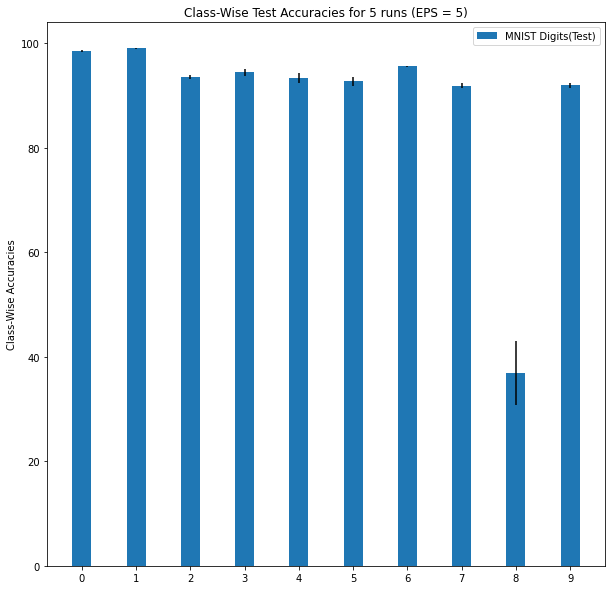

In [ ]:
import matplotlib.pyplot as plt


labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize = (10,10))

ax.bar(labels, mean_class_acc_test, width, yerr=std_class_acc_test, label='MNIST Digits(Test)')

ax.set_ylabel('Class-Wise Accuracies')
ax.set_title('Class-Wise Test Accuracies for 5 runs (EPS = 5)')
ax.legend()

plt.show()